In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import skorch
import torch
from skorch import NeuralNetClassifier
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from scipy.stats import entropy
import random
import h5py
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import FeatureAgglomeration

In [28]:
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.utils import get_statistics
from torch.utils.data import DataLoader, Dataset

In [3]:
from scifAI.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

In [4]:


# Compare Algorithms
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [5]:
from sklearn.random_projection import GaussianRandomProjection

In [6]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


def classification_complete_report(y_true, y_pred ,labels = None  ): 
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    cm = confusion_matrix(y_true, y_pred,labels= labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print(15*"----")

In [7]:
metadata = pd.read_csv("/pstore/data/DS4/synapse_data_features/metadata_subset.csv.gz")
metadata

/pstore/apps/Python/3.8.3-2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,5156,unlabeled,-1
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,32020,unlabeled,-1
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,55974,unlabeled,-1
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,15150,unlabeled,-1
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,44814,unlabeled,-1
...,...,...,...,...,...,...,...
1065962,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,72493,unlabeled,-1
1065963,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,106656,unlabeled,-1
1065964,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,110990,unlabeled,-1
1065965,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,71451,unlabeled,-1


In [8]:
metadata.set.unique()

array(['unlabeled', 'labeled', 'train', 'test', 'validation'],
      dtype=object)

In [9]:
indx = metadata.condition.isin(["-SEA","+SEA"])
metadata = metadata.loc[indx, :].reset_index(drop = True )

In [10]:
set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'T_cell_with_B_cell_fragments',
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'No_cell_cell_interaction', 
                        'Multiplets'] 

indx = metadata.set.isin([ "train", "validation","test" ])
indx = indx & metadata.label.isin(set_of_interesting_classes)

train_index = metadata["set"] == "train"
train_index = train_index & metadata.label.isin(set_of_interesting_classes)
train_index = train_index[train_index].index

validation_index = metadata["set"] == "validation"
validation_index = validation_index & metadata.label.isin(set_of_interesting_classes)
validation_index = validation_index[validation_index].index

test_index = metadata["set"] == "test"
test_index = test_index & metadata.label.isin(set_of_interesting_classes)
test_index = test_index[test_index].index

In [11]:
metadata["set"].unique()

array(['unlabeled', 'labeled', 'train', 'test', 'validation'],
      dtype=object)

In [12]:


label_map = dict()
for i, cl in enumerate(set_of_interesting_classes):
    label_map[cl] = i

label_map['-1'] = -1
label_map[-1] = -1


In [13]:
label_map

{'B_cell': 0,
 'T_cell': 1,
 'T_cell_with_signaling': 2,
 'T_cell_with_B_cell_fragments': 3,
 'B_T_cell_in_one_layer': 4,
 'Synapses_without_signaling': 5,
 'Synapses_with_signaling': 6,
 'No_cell_cell_interaction': 7,
 'Multiplets': 8,
 '-1': -1,
 -1: -1}

In [14]:
channels = {
     "Ch1": ("Greys", "BF"),  
     "Ch2": ("Greens", "Antibody"),
     "Ch3": ("Reds", "CD18"),
     "Ch4": ("Oranges", "F-Actin"),
     "Ch6": ("RdPu", "MHCII"),
     "Ch7": ("Purples", "CD3/CD4"),
     "Ch11": ("Blues", "P-CD3zeta"),
     "Ch12": ("Greens", "Live-Dead")
 }

In [16]:
import os

seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

In [22]:
selected_channels = [0,3,4,5,6]
model_dir = "models"
log_dir = "logs"
scaling_factor = 4095.
reshape_size = 160
train_transform = [
         transforms.RandomVerticalFlip(),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(45)
        ]
test_transform = [ ]

In [26]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose(train_transform))

In [31]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=6)


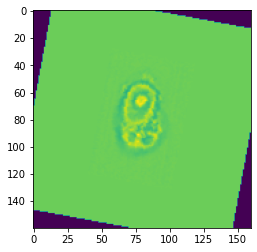

In [32]:
plt.imshow(train_dataset[0][0][0])


In [33]:
statistics = get_statistics(train_loader, selected_channels=selected_channels)


100%|██████████| 23/23 [01:48<00:00,  4.73s/it]

statistics used: {'min': tensor([0., 0., 0., 0., 0.]), 'p01': tensor([0., 0., 0., 0., 0.]), 'p05': tensor([0., 0., 0., 0., 0.]), 'p25': tensor([0.1941, 0.0081, 0.0092, 0.0126, 0.0094]), 'p50': tensor([0.1951, 0.0152, 0.0119, 0.0187, 0.0096]), 'p75': tensor([0.1956, 0.0199, 0.0181, 0.0253, 0.0098]), 'p95': tensor([0.1970, 0.0399, 0.0321, 0.0363, 0.0101]), 'p99': tensor([0.2068, 0.0828, 0.0681, 0.0901, 0.0111]), 'max': tensor([0.3420, 0.7878, 0.4514, 0.3425, 0.1240]), 'mean': tensor([0.1721, 0.0172, 0.0147, 0.0198, 0.0085]), 'std': tensor([0.0629, 0.0195, 0.0135, 0.0153, 0.0032])}


In [23]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [24]:
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [25]:
import torch.nn as nn
from torchvision.models import resnet152, resnet18, resnet34, resnet50
import torch.nn.functional as F

class ResNet18Modified(nn.Module):
    def __init__(self,  num_channels=3, num_classes=3, pretrained=True, progress=True, **kwargs):
        super().__init__()
        model = resnet18(pretrained=pretrained)
        if num_channels != 3:
            model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=(7, 7),
                                    stride=(2, 2), padding=(3, 3), bias=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        self.model = model

    def forward(self, x):                
        return self.model(x)

In [34]:
resnet18_modified = ResNet18Modified(len(selected_channels),
                                     len(set_of_interesting_classes), 
                                     pretrained = True)

In [47]:
train_transform = transforms.Compose([ 
        MinMaxScaler(           min_in =  statistics["p05"] , 
                                max_in =  statistics["p95"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomResizedCrop(reshape_size, scale=(0.6, 1.0), ratio=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.01),
])



train_dataset = DatasetGenerator(metadata.loc[train_index.tolist(),:], 
                                 reshape_size=reshape_size, 
                                label_map=label_map, 
                                 transform = train_transform,
                                selected_channels=selected_channels)

In [48]:
label_map

{'B_cell': 0,
 'T_cell': 1,
 'T_cell_with_signaling': 2,
 'T_cell_with_B_cell_fragments': 3,
 'B_T_cell_in_one_layer': 4,
 'Synapses_without_signaling': 5,
 'Synapses_with_signaling': 6,
 'No_cell_cell_interaction': 7,
 'Multiplets': 8,
 '-1': -1,
 -1: -1}

tensor(6)


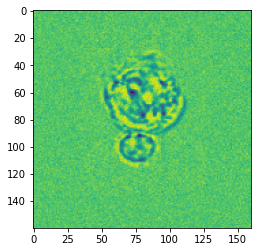

In [49]:
i = 40
plt.imshow(train_dataset[i][0][0,:,:])
print(train_dataset[i][1])

In [51]:
validation_transforms =  transforms.Compose([ 
        MinMaxScaler(           min_in =  statistics["p05"] , 
                                max_in =  statistics["p95"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.01),
])

test_transforms =  transforms.Compose([ 
        MinMaxScaler(           min_in =  statistics["p05"] , 
                                max_in =  statistics["p95"] , 
                                min_out =  0. , 
                                max_out =  1.),
])

validation_dataset_resnet_18 = DatasetGenerator(metadata.loc[validation_index.tolist(),:],
                                 reshape_size=reshape_size, 
                                label_map=label_map,
                                transform=validation_transforms, 
                                selected_channels=selected_channels)

test_dataset_resnet_18 = DatasetGenerator(metadata.loc[test_index.tolist(),:],
                                 reshape_size=reshape_size, 
                                label_map=label_map,
                                transform=test_transforms, 
                                selected_channels=selected_channels)

In [52]:


#resnet18_modified.load_state_dict(torch.load('supervised_learning_synapse_model.pth')) 

#lr_scheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.6)
lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.1, patience=10)
#checkpoint = Checkpoint(f_params='resnet_18_imagenet_pretraiend_supervised_learning.pth', monitor='valid_acc_best')


epoch_scoring = EpochScoring("f1_macro", 
                             name =  "valid_f1_macro", 
                             on_train = False,
                             lower_is_better = False)

early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                               patience=100, 
                               threshold=0.0001, 
                               threshold_mode='rel', 
                               lower_is_better=False)

model = NeuralNetClassifier(    
    resnet18_modified, 
    criterion=nn.CrossEntropyLoss,
    lr=0.01,
    batch_size=128,
    max_epochs=1000,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    callbacks=[lr_scheduler,epoch_scoring, early_stopping],
    train_split=predefined_split(validation_dataset_resnet_18),
    device="cuda",
    warm_start=True)

In [53]:
model = model.fit(train_dataset, y = None)

  epoch    train_loss    valid_acc    valid_f1_macro    valid_loss      dur
-------  ------------  -----------  ----------------  ------------  -------
      1        2.5918       0.1040            0.0323      996.9839  17.2756
      2        1.5367       0.2845            0.2339        6.4951  8.2872
      3        1.1587       0.4405            0.3177        1.5008  8.1691
      4        1.0185       0.3365            0.2945        2.4565  7.9897
      5        0.8546       0.6047            0.5398        0.8907  8.0197
      6        0.8262       0.3912            0.3389        2.1884  7.9043
      7        0.7979       0.5896            0.5377        0.9226  7.9227
      8        0.7240       0.4118            0.3900        1.8064  7.9823
      9        0.7191       0.6033            0.5651        1.0453  7.8961
     10        0.6750       0.5157            0.4241        1.3815  7.8984
     11        0.6821       0.5363            0.5048        4.3463  7.9689
     12        0.6817 

     99        0.2262       0.8331            0.8268        0.5651  7.8948
    100        0.2403       0.7073            0.6981        1.3332  7.8749
    101        0.2304       0.7565            0.7416        0.7722  7.9453
    102        0.2379       0.7633            0.7393        1.2511  7.8971
    103        0.2438       0.7415            0.7255        1.3875  7.8541
    104        0.2496       0.7196            0.6714        1.7244  7.8654
    105        0.2537       0.7196            0.6954        1.4466  7.9470
    106        0.2355       0.8372            0.8285        0.4775  7.9043
    107        0.2123       0.8044            0.7950        0.6512  7.9637
    108        0.2330       0.7483            0.7223        0.7655  7.9719
    109        0.2477       0.7168            0.7212        1.0499  7.9186
    110        0.2442       0.8153            0.8058        0.7282  7.9245
    111        0.2289       0.8003            0.7919        0.6343  7.9099
    112        0.2380    

    203        0.0684       0.8482            0.8440        0.6646  7.8980
    204        0.0550       0.8550            0.8509        0.6470  7.9184
    205        0.0601       0.8358            0.8319        0.7151  7.8320
    206        0.0621       0.8577            0.8545        0.6496  7.9201
    207        0.0572       0.8564            0.8523        0.6271  7.9467
    208        0.0590       0.8509            0.8473        0.6743  7.9261
    209        0.0573       0.8495            0.8454        0.6632  7.9359
    210        0.0614       0.8495            0.8463        0.6718  7.9114
    211        0.0602       0.8495            0.8464        0.6795  7.9467
    212        0.0625       0.8495            0.8458        0.6982  7.9545
    213        0.0575       0.8468            0.8432        0.6992  7.9223
    214        0.0547       0.8509            0.8475        0.6892  7.9087
    215        0.0579       0.8509            0.8477        0.7246  7.9204
    216        0.0523    

In [54]:
## START from here

              precision    recall  f1-score   support

           0       0.97      0.98      0.97        89
           1       0.88      0.88      0.88        94
           2       0.82      0.83      0.82        70
           3       0.83      0.92      0.87        88
           4       0.87      0.73      0.79        74
           5       0.67      0.70      0.68        69
           6       0.74      0.78      0.76        94
           7       0.91      0.88      0.89        82
           8       0.96      0.90      0.93        71

    accuracy                           0.85       731
   macro avg       0.85      0.84      0.85       731
weighted avg       0.85      0.85      0.85       731

------------------------------------------------------------
matthews correlation coeff: 0.8290
Cohen Kappa score: 0.8288
Accuracy: 0.8482 & balanced Accuracy: 0.8434
macro F1 score: 0.8451 & micro F1 score: 0.8482
macro Precision score: 0.8491 & micro Precision score: 0.8482
macro Recall score

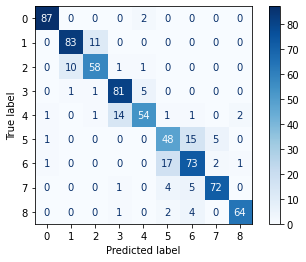

------------------------------------------------------------


In [55]:
preds = model.predict(validation_dataset_resnet_18)

classification_complete_report([label_map[t] for t in validation_dataset_resnet_18.metadata.label], 
                               preds  )

In [56]:
set_of_interesting_classes

['B_cell',
 'T_cell',
 'T_cell_with_signaling',
 'T_cell_with_B_cell_fragments',
 'B_T_cell_in_one_layer',
 'Synapses_without_signaling',
 'Synapses_with_signaling',
 'No_cell_cell_interaction',
 'Multiplets']

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       190
           1       0.91      0.89      0.90       200
           2       0.86      0.84      0.85       148
           3       0.90      0.92      0.91       189
           4       0.85      0.91      0.88       161
           5       0.61      0.73      0.67       147
           6       0.78      0.77      0.77       196
           7       0.94      0.91      0.92       182
           8       0.97      0.77      0.86       154

    accuracy                           0.86      1567
   macro avg       0.86      0.86      0.86      1567
weighted avg       0.87      0.86      0.86      1567

------------------------------------------------------------
matthews correlation coeff: 0.8451
Cohen Kappa score: 0.8447
Accuracy: 0.8622 & balanced Accuracy: 0.8577
macro F1 score: 0.8590 & micro F1 score: 0.8622
macro Precision score: 0.8646 & micro Precision score: 0.8622
macro Recall score

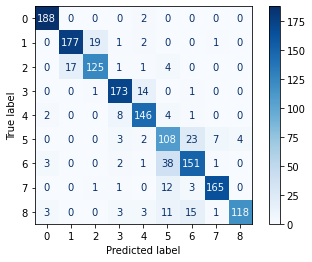

------------------------------------------------------------


In [57]:
preds = model.predict(test_dataset_resnet_18)
#preds =  [inv_map[int(t)] for t in preds]

classification_complete_report([label_map[t] for t in test_dataset_resnet_18.metadata.label],  preds   )